In [19]:
#!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /home/matteo/snap/jupyter/common/lib/python3.7/site-packages (0.1.54)


In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
import chart_studio as cs
from IPython.display import display, HTML
import yfinance as yf
from datetime import datetime, date
import seaborn as sns
%matplotlib inline


/home/matteo/snap/jupyter/common/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#estrapolo i dati  per trovare la combinazione di portafoglio adeguata

start_date = '2016-01-01'
end_date = '2019-12-31'
capitale = 100
assets= ['T', 'WMB', 'IRM', 'MO', 'PM','D','PGR','GIL','IBM','VZ', 'PPL', 'K','DUK', 'PFE','PSA',
       'IP', 'SO','KMI','XOM','WMT']

#Dataframe per valori di chiusura
pf_data = pd.DataFrame()
#Dataframe per i dividendi
date_today = datetime.now()
days = pd.date_range(start_date, end_date , freq='D')
pf_div = pd.DataFrame(index = days)

#Riempio il dataframe pf_data con le diverse stock
for a in assets:
    pf_data[a]= wb.DataReader(a,data_source='yahoo', start = start_date , end= end_date)['Adj Close']

#Riempio il dataframe pf_div con i dividendi delle stock
for a in range(len(assets)):
    
    stock = yf.Ticker(assets[a])
    pf_div[assets[a]]=stock.dividends
    print(stock.info)

pf_div = pf_div.dropna(how='all') #cancella le righe che sono tutte NaN
pf_div.fillna(0, inplace=True) # trasmormo Nan in 0 per fare calcoli

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [4]:
#calcolo ritorno logaritmico gioraliero degli assets mel periodo selezionato
log_returns =np.log(pf_data/pf_data.shift(1))
#percentuale di ritorno annua media di ogni stocks
mean_annual_return = round(log_returns.mean()*250*100,1)
#percentuale di volatilità annua media di ogni stock
mean_annual_volatility = round(log_returns.std()*250**0.5*100,1) 
#valore dei dividendi medio annua per ogni stock
mean_annual_dividend = round((pd.DataFrame(pf_div.resample('Y').sum())).mean(),2)
# rapporto tra prezzo stock e i suoi dividendi
dividends_stock = round((mean_annual_dividend / pf_data.values[0])*100,2)

#Creo Dataframe per un review veloce
review = pd.DataFrame(index = assets)
review['Mean annual Return [%]'] = mean_annual_return
review['Mean annual Volatility [%]'] = mean_annual_volatility
review['Mean annual Dividends [$/N°stock]'] = mean_annual_dividend
review['Dividends / Stock price'] = dividends_stock
review

,Mean annual Return [%],Mean annual Volatility [%],Mean annual Dividends [$/N°stock],Dividends / Stock price
T,8.6,18.6,1.98,7.38
WMB,3.2,45.6,1.44,7.09
IRM,10.8,22.4,2.27,11.26
MO,1.2,20.6,2.79,6.04
PM,4.5,21.6,4.62,6.61
D,9.3,15.6,3.21,5.70
PGR,23.7,19.4,1.38,4.96
GIL,2.6,27.4,0.42,1.59
IBM,4.0,20.4,6.36,5.64
VZ,11.7,17.3,2.35,6.26


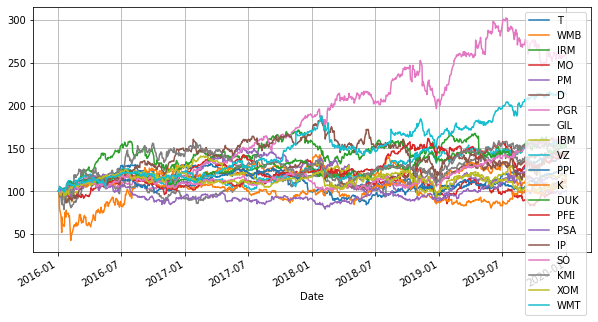

In [5]:
#normalizzo e plotto l'andamento (!!!!!importante normalizzare cosi posso paragonare i risultati)
(pf_data/pf_data.iloc[0]*100).plot(figsize=(10,5), grid= True);

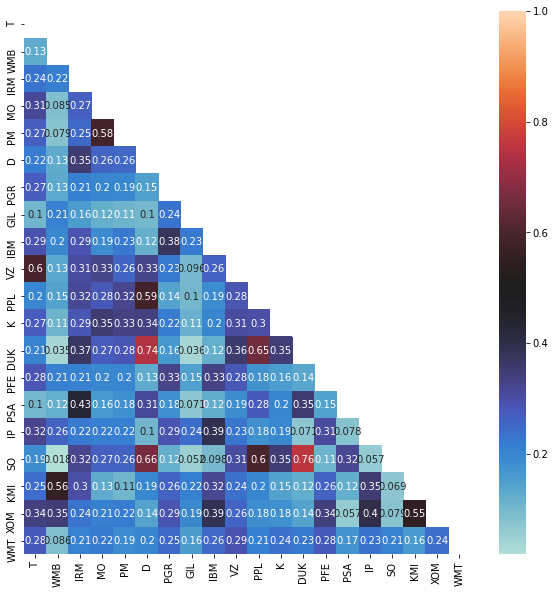

In [8]:
#cambia center per capire meglio la correlazione 
correlation = log_returns.corr()
mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10,10))
sns.heatmap(correlation,center=0.5,annot=True,mask=mask);

In [9]:
#genero tot combinazioni di peso per il tuo portafoglio (nel ciclo for inserisci il n combinazioni) per
#valutare tutte le possibili combinazioni di peso, scegliendo poi quella ottima
num_assets=len(assets)
pfoglio_returns=[]
pfoglio_volatilities=[]
pfoglio_weights=[]
pfoglio_sharpe_ratio = []
pfoglio_dividends = []
pfoglio_sharpe_yield = []
risk_free = 0.025 #bot 10 anni US collegare a yahoo
stock_value = (pf_data.values[0]) #valore della stock allo start_date
                                  #verificare che il primo valore non sia un NaN 

np.random.seed(1373)
for x in range (5000):
    
    weights=np.random.random(num_assets)
    weights/=np.sum(weights)
    weights = np.around(weights,4)
    returns = np.around(np.sum(weights* log_returns.mean())*250,4)  
    volatility = np.around(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*250,weights))),4)
    sharpe_ratio = np.around((returns - risk_free)/volatility,2)
    n_stocks = capitale*weights/stock_value
    dividends = np.around(np.sum((pf_div*n_stocks).sum(axis = 0)),2)
    sharpe_yield = np.round(sharpe_ratio/dividends,3) #indicatore per trovare il miglior rapporto sharpe_divid
    
    pfoglio_weights.append(weights)
    pfoglio_returns.append(returns)
    pfoglio_volatilities.append(volatility)
    pfoglio_sharpe_ratio.append(sharpe_ratio)
    pfoglio_dividends.append(dividends)
    pfoglio_sharpe_yield.append(sharpe_yield)
    

portfoglios=pd.DataFrame({'Return': pfoglio_returns, 'Volatility': pfoglio_volatilities,
                          'Sharpe Ratio': pfoglio_sharpe_ratio, 'Dividends': pfoglio_dividends,
                          'Sharpe Yield': pfoglio_sharpe_yield})
portfoglios=pd.concat([portfoglios, pd.DataFrame(pfoglio_weights)], axis=1);
columns_name = [ 'Returns', 'Volatility','Sharpe Ratio', 'Dividends', 'Sharpe Yield'] + ["Weight_" + assets for assets in assets]
portfoglios.columns= columns_name

In [11]:
display(portfoglios)

,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,...,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
0,0.0761,0.1191,0.43,22.67,0.019,0.0072,0.0737,0.0794,0.0695,0.0425,...,0.0742,0.0521,0.0245,0.0604,0.0717,0.0417,0.0699,0.0851,0.0457,0.0126
1,0.0789,0.1104,0.49,22.38,0.022,0.0196,0.0669,0.0479,0.0774,0.0872,...,0.0048,0.0197,0.0800,0.0239,0.0650,0.0560,0.0849,0.0039,0.0036,0.0527
2,0.0732,0.1290,0.37,21.87,0.017,0.0531,0.1041,0.0299,0.0576,0.0674,...,0.0029,0.0014,0.0080,0.0646,0.0876,0.0859,0.0113,0.0632,0.1059,0.0096
3,0.0933,0.1058,0.65,21.95,0.030,0.0317,0.0004,0.0857,0.0326,0.0033,...,0.0672,0.0389,0.0654,0.0769,0.0265,0.0335,0.0697,0.0267,0.0387,0.0781
4,0.0827,0.1106,0.52,23.00,0.023,0.0749,0.0369,0.0731,0.0251,0.0756,...,0.0105,0.0699,0.0600,0.0653,0.0746,0.0372,0.0276,0.0661,0.0472,0.0597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0666,0.1270,0.33,25.13,0.013,0.0501,0.1011,0.0987,0.1003,0.1042,...,0.0979,0.0258,0.1031,0.0302,0.0380,0.0284,0.0090,0.0867,0.0091,0.0121
4996,0.0980,0.1170,0.62,22.56,0.027,0.0137,0.0837,0.0639,0.0975,0.0222,...,0.0061,0.0563,0.0370,0.0310,0.0326,0.0542,0.0292,0.0291,0.0632,0.1356
4997,0.0921,0.1125,0.60,21.36,0.028,0.0135,0.0709,0.0051,0.0887,0.0705,...,0.0168,0.0469,0.0075,0.0674,0.0424,0.0770,0.0871,0.0399,0.0144,0.1009
4998,0.0782,0.1146,0.46,21.36,0.022,0.0634,0.0836,0.0089,0.0631,0.0145,...,0.0797,0.0057,0.0420,0.0287,0.0700,0.0290,0.0750,0.0458,0.0795,0.0321


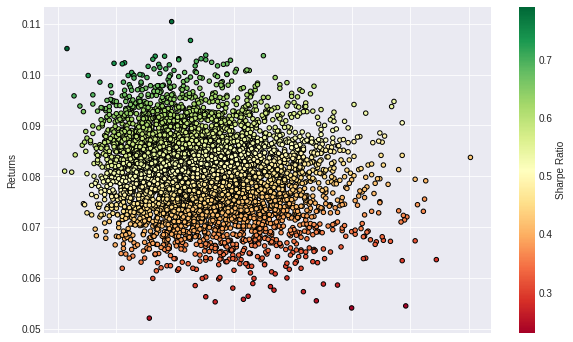

In [12]:
#plottiamo i dati delle combinazioni di portafoglio 
#portfoglios.iplot(x='Volatility', y='Returns', kind='scatter',mode='markers',size=5);
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                  c='Sharpe Ratio', cmap='RdYlGn', edgecolors='black',grid=True);


In [13]:
min_volatility = portfoglios['Volatility'].min()
max_sharpe = portfoglios['Sharpe Ratio'].max()
max_yield = portfoglios['Dividends'].max()
max_yieldsharpe = portfoglios['Sharpe Yield'].max()
# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = portfoglios.loc[portfoglios['Sharpe Ratio'] == max_sharpe]
min_variance_port = portfoglios.loc[portfoglios['Volatility'] == min_volatility]
dividends_port = portfoglios.loc[portfoglios['Dividends'] == max_yield]
maximize_sharpeyield_port = portfoglios.loc[portfoglios['Sharpe Yield'] == max_yieldsharpe]

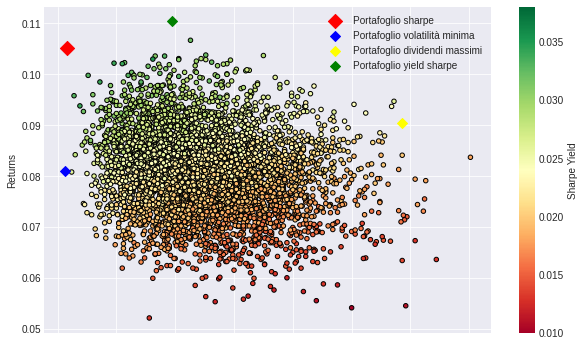

In [15]:
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                  c='Sharpe Yield', cmap='RdYlGn', edgecolors='black',grid=True);
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], 
            c='red', marker='D', s=100 , label = 'Portafoglio sharpe');
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], 
            c='blue', marker='D', s=50, label = 'Portafoglio volatilità minima');
plt.scatter(x= dividends_port['Volatility'], y= dividends_port['Returns'], 
            c='yellow', marker='D', s=50, label = 'Portafoglio dividendi massimi');
plt.scatter(x= maximize_sharpeyield_port['Volatility'], y= maximize_sharpeyield_port['Returns'], 
            c='green', marker='D', s=50, label = 'Portafoglio yield sharpe');
plt.legend();


In [16]:
display(min_variance_port)
display(sharpe_portfolio)
display(maximize_sharpeyield_port)
display(dividends_port)

,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,...,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
4934,0.081,0.1006,0.56,20.49,0.027,0.0263,0.002,0.0051,0.0745,0.0018,...,0.0721,0.0404,0.0861,0.0811,0.0668,0.008,0.0852,0.037,0.0816,0.0837


,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,...,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
1560,0.1051,0.1008,0.79,21.36,0.037,0.069,0.0194,0.0081,0.0225,0.0196,...,0.0305,0.0176,0.1218,0.111,0.0591,0.0357,0.1188,0.0025,0.0055,0.065


,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,...,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
2606,0.1104,0.1097,0.78,20.48,0.038,0.0079,0.0038,0.0247,0.0334,0.0053,...,0.1138,0.0059,0.0567,0.0455,0.0813,0.0096,0.0653,0.1317,0.0007,0.0936


,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,...,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
2935,0.0905,0.1293,0.51,25.67,0.02,0.0661,0.0895,0.1109,0.0408,0.0718,...,0.0161,0.0306,0.0131,0.0773,0.0087,0.0963,0.0333,0.1058,0.014,0.0026


In [17]:
weight_sharpe = sharpe_portfolio.iloc[:, 5:(len(assets)+5)]
weight_minvar = min_variance_port.iloc[:, 5:(len(assets)+5)] # +3 per aggiungere le prime tre colonne
weight_sharpe

,Weight_T,Weight_WMB,Weight_IRM,Weight_MO,Weight_PM,Weight_D,Weight_PGR,Weight_GIL,Weight_IBM,Weight_VZ,Weight_PPL,Weight_K,Weight_DUK,Weight_PFE,Weight_PSA,Weight_IP,Weight_SO,Weight_KMI,Weight_XOM,Weight_WMT
1560,0.069,0.0194,0.0081,0.0225,0.0196,0.0887,0.1244,0.0469,0.0229,0.0111,0.0305,0.0176,0.1218,0.111,0.0591,0.0357,0.1188,0.0025,0.0055,0.065


In [18]:

review = pd.DataFrame(index = assets)
review['Weight Sharpe Portfolio [$]'] = np.around(weight_sharpe.values[0]*capitale,1) 
review['Weight Min Variance Portfolio [$]'] = np.around(weight_minvar.values[0]*capitale,1) 
review

,Weight Sharpe Portfolio [$],Weight Min Variance Portfolio [$]
T,6.9,2.6
WMB,1.9,0.2
IRM,0.8,0.5
MO,2.2,7.4
PM,2.0,0.2
D,8.9,5.2
PGR,12.4,2.5
GIL,4.7,5.4
IBM,2.3,3.8
VZ,1.1,7.9


TypeError: only size-1 arrays can be converted to Python scalars

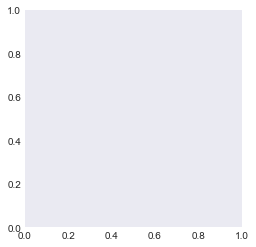

In [63]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(weight_sharpe, wedgeprops=dict(width=0.5), startangle=-40)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(assets[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Sharpe Portfolio");

ax.legend(wedges, review.iloc[:,0],
          title="Weights [$]",
          loc="center left",
          bbox_to_anchor=(1.5, 0, 0.5, 1))
plt.show();

In [ ]:
#testiamo i tuoi portafoglio dal 2017 in poi (fingo che ci troviamo nel 2017, costruisco i portafogli con i dati fino al 2017)
#dal 2017 ad oggi lo considero futuro.
#vediamo cosa succede

In [305]:
#estrapolo i dati dal 2017 in poi 

pf_data2 = pd.DataFrame()

for a in assets:
    pf_data2[a]= wb.DataReader(a,data_source='yahoo', start ='2017-1-1')['Adj Close']

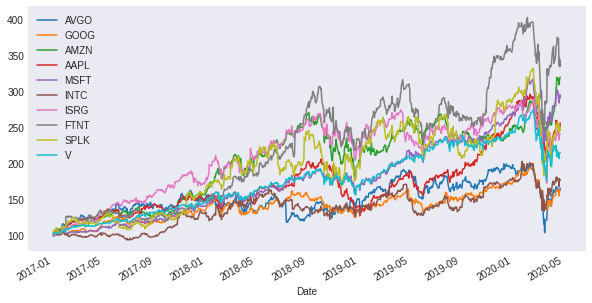

In [307]:
#adesso inizia il processo di calcolo dei rendimenti e volaitilà del tuo portafoglio e quello fatto per avere volatilità minima
#calcolo ritorno logaritmico gioraliero degli assets
log_returns2 =np.log(pf_data2/pf_data2.shift(1))

In [308]:
#percentuale di ritorno annua media di ogni stocks
log_returns2.mean()*250*100

AVGO    15.058821
GOOG    14.631649
AMZN    34.931452
AAPL    28.203034
MSFT    32.524556
INTC    16.953308
ISRG    26.393694
FTNT    37.023962
SPLK    26.926891
V       23.007487
dtype: float64

In [309]:
rit_sharpe=np.sum(weight_sharpe.values[0] * log_returns2.mean())*250
vol_sharpe=np.sqrt(np.dot(weight_sharpe.values[0].T, np.dot(log_returns2.cov()*250,weight_sharpe.values[0])))

rit_min=np.sum(weight_minvar.values[0] * log_returns2.mean())*250
vol_min=np.sqrt(np.dot(weight_minvar.values[0].T, np.dot(log_returns2.cov()*250,weight_minvar.values[0])))
print(rit_sharpe)
print(rit_min)
print(vol_sharpe)
print(vol_min)

0.25586435868758806
0.23575686616414024
0.2614639527604971
0.2587793848747


In [310]:
#genero tot combinazioni di peso per il tuo portafoglio (nel ciclo for inserisci il n combinazioni) per
#valutare tutte le possibili combinazioni di peso
num_assets=len(assets)
pfoglio_returns2=[]
pfoglio_volatilities2=[]
pweights2=[]
for x in range (50000):
    weights2=np.random.random(num_assets)
    weights2/=np.sum(weights2)
    pweights2.append(weights2)
   
    pfoglio_returns2.append(np.sum(weights2* log_returns2.mean())*250)
    pfoglio_volatilities2.append(np.sqrt(np.dot(weights2.T, np.dot(log_returns2.cov()*250,weights2))))

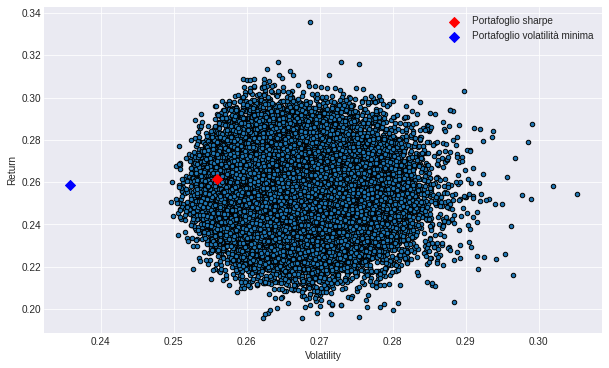

In [311]:
#plottiamo i dati delle combinazioni di portafoglio 
portfoglios=pd.DataFrame({'Return': pfoglio_returns2, 'Volatility': pfoglio_volatilities2})
plt.style.use('seaborn-dark')
portfoglios.plot( x='Volatility', y='Return', kind='scatter',figsize=(10,6),edgecolors='black',
                  grid=True);
plt.scatter(x=rit_sharpe, y= vol_sharpe, 
            c='red', marker='D', s=50 , label = 'Portafoglio sharpe');
plt.scatter(x= rit_min, y= vol_min, 
            c='blue', marker='D', s=50, label = 'Portafoglio volatilità minima');
plt.legend();


